# Stock analysis & Markowitz efficient frontier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
ydex = pd.read_csv('YDEX_250501_250623.csv', delimiter = ';')
rosn = pd.read_csv('ROSN_250501_250623.csv', delimiter = ';')
sber = pd.read_csv('SBER_250501_250623.csv', delimiter = ';')
gazp = pd.read_csv('GAZP_250501_250623.csv', delimiter = ';')

FileNotFoundError: [Errno 2] No such file or directory: '../finance/data/YDEX_250501_250623.csv'

In [298]:
stocks = pd.concat([ydex['<CLOSE>'], rosn['<CLOSE>'], sber['<CLOSE>'], gazp['<CLOSE>']], axis = 1)
stocks.columns = ['YDEX', 'ROSN', 'SBER', 'GAZP']
stocks.head()

,YDEX,ROSN,SBER,GAZP
0,3905.5,435.70,299.96,138.89
1,3940.5,438.15,300.70,139.58
2,3948.5,439.70,301.80,141.10
3,3860.0,426.70,294.64,135.09
4,4013.0,430.25,302.02,137.71


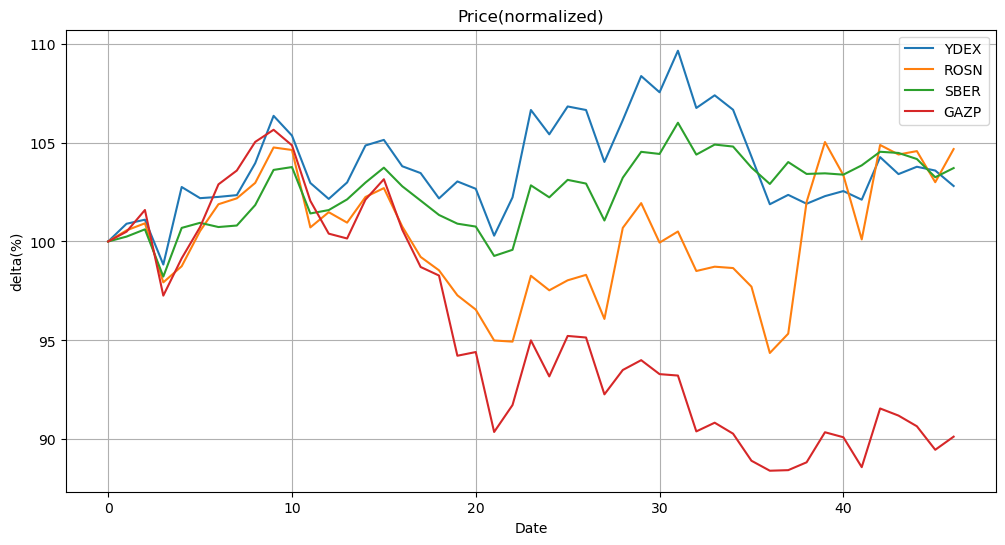

In [300]:
(stocks / stocks.iloc[0] * 100).plot(figsize=(12, 6))  
plt.title('Price(normalized)')
plt.xlabel('Date')
plt.ylabel('delta(%)')
plt.grid(True)
plt.show()

# Returns

\begin{equation}
    r_t = \frac{p_t}{p_{t - 1}}
\end{equation}

In [303]:
returns = stocks / stocks.shift(1)
returns.head()

,YDEX,ROSN,SBER,GAZP
0,NaN,NaN,NaN,NaN
1,1.008962,1.005623,1.002467,1.004968
2,1.002030,1.003538,1.003658,1.010890
3,0.977586,0.970434,0.976276,0.957406
4,1.039637,1.008320,1.025048,1.019394


# Log returns

\begin{equation}
    \log r_t = \log \frac{p_t}{p_{t - 1}}
\end{equation}

In [306]:
log_returns = np.log(returns)
log_returns.head()

,YDEX,ROSN,SBER,GAZP
0,NaN,NaN,NaN,NaN
1,0.008922,0.005607,0.002464,0.004956
2,0.002028,0.003531,0.003651,0.010831
3,-0.022669,-0.030011,-0.024010,-0.043528
4,0.038872,0.008285,0.024739,0.019209


# Sharpe ratio

Sharpe ratio is defined as

\begin{equation}
    SR(w) = \frac{R(w) - R_f}{\sigma(w)}
\end{equation}

\begin{equation}
    w = [w_1, w_2, w_3, w_4]
\end{equation}

\begin{equation}
    \sum_{i = 1}^4 w_k = 1
\end{equation}

- $R(w)$ — log returns  
- $\sigma(w)$ — volatility  
- $R_f$ — risk-free rate
- $w$ — weights of portfolio

Since we will look for max $SR(w)$ and $R_f$ is common for all $w$'s, then we shall compute

\begin{equation}
    R(w) = w^{T}\log(r)
\end{equation}

\begin{equation}
    \sigma(w) = \sqrt{w^{T}\Sigma w}
\end{equation}

- $\Sigma$ — covariance matrix of log returns

\begin{equation}
    SR(w) \sim \frac{w^{T}\log(r)}{\sqrt{w^{T}\Sigma w}}
\end{equation}

# Return vs Volatility Chart

Generating (almost) all possible portfolios

In [310]:
num_of_portfolios = 100000
weight = np.zeros((num_of_portfolios, 4))
expected_return = np.zeros(num_of_portfolios)
expected_volatility = np.zeros(num_of_portfolios)
sharpe = np.zeros(num_of_portfolios)

mean_log_return = log_returns.mean()
cov_matrix = log_returns.cov()

for k in range(num_of_portfolios):
    # Generate random weight vector
    w = np.random.random(4)
    w = w / np.sum(w)
    weight[k, :] = w
    # Expected log return
    expected_return[k] = np.sum(mean_log_return * w)
    # Expected volatility 
    expected_volatility[k] = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
    # Sharpe ratio
    sharpe[k] = expected_return[k] / expected_volatility[k]
    

# Maximize Sharpe ratio

Find weigths of maximum Sharpe ratio portfolio

In [313]:
max_index_sharpe = sharpe.argmax()
weight[max_index_sharpe]

array([0.01978537, 0.03624233, 0.94259718, 0.00137513])

# Plot efficient frontier

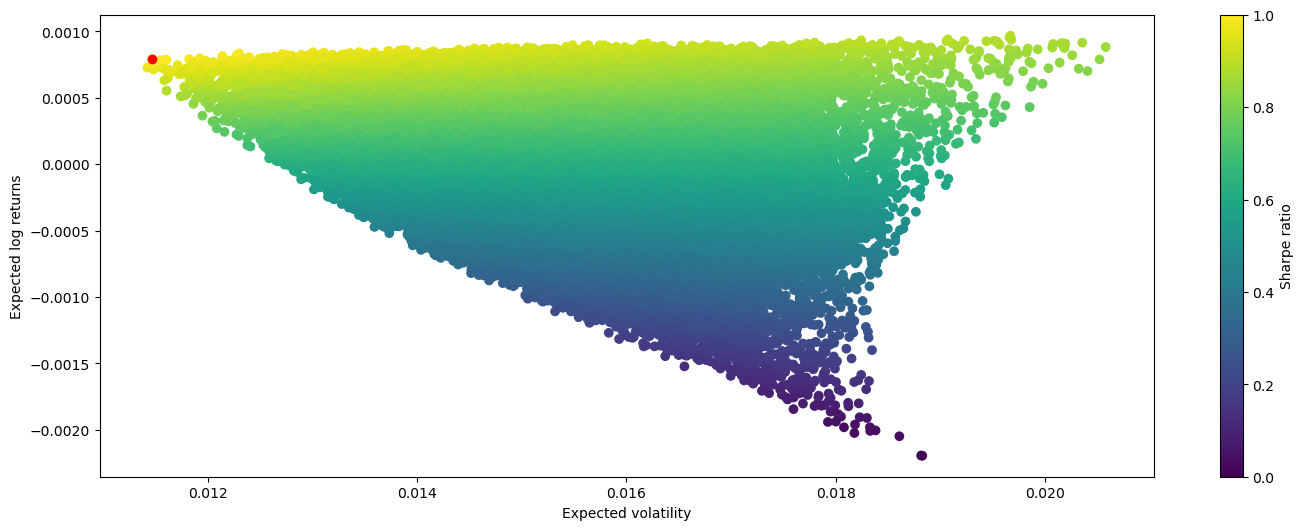

In [316]:
plt.figure(figsize=(17, 6))
plt.scatter(expected_volatility, expected_return, c = sharpe)
plt.scatter(expected_volatility[max_index_sharpe], expected_return[max_index_sharpe], c = 'red')
plt.xlabel('Expected volatility')
plt.ylabel('Expected log returns')
plt.colorbar(label = 'Sharpe ratio')
plt.show()

# Another way to find optimal portfolio

Solve optimization problem

$$
\begin{aligned}
& \underset{\mathbf{w}}{\text{minimize}} 
& & \mathbf{w}^T \Sigma \mathbf{w} \\
& \text{subject to} 
& & \mathbf{p}^T \mathbf{w} \geq r_{\text{min}} \\
& & & \mathbf{w} \geq 0 \\
& & & 1^{T}\mathbf{w} = 1
\end{aligned}
$$

or another way

$$
\begin{aligned}
& \underset{\mathbf{w}}{\text{maximize}} 
& & SR(\mathbf{w}) \\
& \text{subject to} 
& & \mathbf{w} \geq 0 \\
& & &  1^{T}\mathbf{w} = 1
\end{aligned}
$$

In [319]:
from scipy.optimize import minimize

In [321]:
def negative_sharpe(w):
    w = np.array(w)
    R = np.sum(mean_log_return * w)
    V = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
    SR = R / V
    return -SR

def check_sum_to_one(w):
    return np.sum(w) - 1

w0 = [0.25, 0.25, 0.25, 0.25]
bounds = ((0,1), (0,1), (0,1), (0,1))
constraints = ({'type': 'eq', 'fun': check_sum_to_one})
w_opt = minimize(negative_sharpe, w0, method = 'SLSQP', bounds = bounds, 
                 constraints = constraints)

In [323]:
w_opt

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.07013954670852758
       x: [ 0.000e+00  4.876e-02  9.512e-01  0.000e+00]
     nit: 11
     jac: [ 3.657e-02  2.371e-05 -1.215e-06  2.878e-01]
    nfev: 55
    njev: 11

In [325]:
w_opt.x.round(3)

array([0.   , 0.049, 0.951, 0.   ])

The results of the two methods are almost identical.

In [328]:
print(f'Weights as  : {weight[max_index_sharpe]}')
print(f'Weights as optimization task solution: {w_opt.x.round(3)}')

Weights as  : [0.01978537 0.03624233 0.94259718 0.00137513]
Weights as optimization task solution: [0.    0.049 0.951 0.   ]
